In [29]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

In [30]:
path_cats_and_dogs = f"{getcwd()}/data/cats-and-dogs.zip"

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [31]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

1500
1500


In [32]:
base_dir = '/tmp/cats-v-dogs'

training_dir = os.path.join(base_dir, 'training')
testing_dir = os.path.join(base_dir, 'testing')

# Directory with our training cat/dog pictures
training_cats_dir = os.path.join(training_dir, 'cats')
training_dogs_dir = os.path.join(training_dir, 'dogs')

# Directory with our testing cat/dog pictures
testing_cats_dir = os.path.join(testing_dir, 'cats')
testing_dogs_dir = os.path.join(testing_dir, 'dogs')

os.mkdir(base_dir)
os.mkdir(training_dir)
os.mkdir(testing_dir)
os.mkdir(training_cats_dir)
os.mkdir(training_dogs_dir)
os.mkdir(testing_cats_dir)
os.mkdir(testing_dogs_dir)

FileExistsError: [Errno 17] File exists: '/tmp/cats-v-dogs'

In [33]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    list = os.listdir(SOURCE)
    sz = len(list)
    random_sample = random.sample(list, sz)
    cut = int(SPLIT_SIZE * sz)
    train = random_sample[:cut]
    test = random_sample[cut:]
    for i in train:
        to_copy = os.path.join(SOURCE, i)
        copy_to = os.path.join(TRAINING, i)
        copyfile(to_copy, copy_to)
    for i in test:
        to_copy = os.path.join(SOURCE, i)
        copy_to = os.path.join(TESTING, i)
        copyfile(to_copy, copy_to)
    

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [34]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

1482
1481
282
281


In [35]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size=10,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

Found 2963 images belonging to 2 classes.


In [36]:
train_datagen_with_adj = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator_with_adj = train_datagen_with_adj.flow_from_directory(training_dir,
                                                    batch_size=10,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

Found 2963 images belonging to 2 classes.


In [37]:
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
validation_generator = validation_datagen.flow_from_directory(testing_dir,
                                                    batch_size=10,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

Found 563 images belonging to 2 classes.


In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

In [39]:
history = model.fit(train_generator, 
                    epochs=2,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/2
297/297 [==============================] - 41s 139ms/step - loss: 0.6767 - acc: 0.6021 - val_loss: 0.5575 - val_acc: 0.7389
Epoch 2/2
297/297 [==============================] - 44s 147ms/step - loss: 0.5840 - acc: 0.7003 - val_loss: 0.5114 - val_acc: 0.7602


In [40]:
history_with_adj = model.fit(train_generator_with_adj, 
                    epochs=2,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/2
297/297 [==============================] - 48s 161ms/step - loss: 0.6359 - acc: 0.6527 - val_loss: 0.5280 - val_acc: 0.7691
Epoch 2/2
297/297 [==============================] - 51s 170ms/step - loss: 0.6251 - acc: 0.6655 - val_loss: 0.5937 - val_acc: 0.6696


Text(0.5, 1.0, 'Training and validation loss')

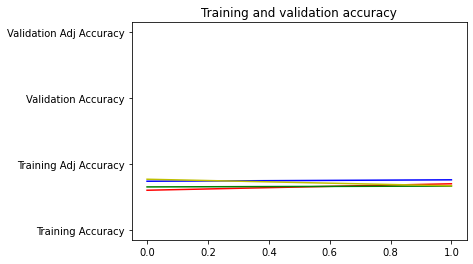

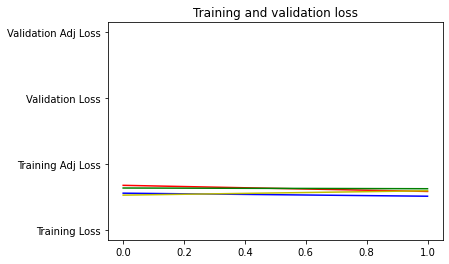

In [41]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
acc_adj=history_with_adj.history['acc']
val_acc=history.history['val_acc']
val_acc_adj=history_with_adj.history['val_acc']
loss=history.history['loss']
loss_adj=history_with_adj.history['loss']
val_loss=history.history['val_loss']
val_loss_adj=history_with_adj.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, acc_adj, 'g', "Training Adj Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.plot(epochs, val_acc_adj, 'y', "Validation Adj Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, loss_adj, 'g', "Training Adj Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.plot(epochs, val_loss_adj, 'y', "Validation Adj Loss")


plt.title('Training and validation loss')